# Final TN Assessment

This is the final assessment for the introduction to tensor networks module. It consists of a number of multiple choice questions, questions with written answers and short coding exercises. Written answers may be given in French or English. This assignment is to be completed **individually**. If you get stuck, refer to the course slides and example notebooks.

## Handing in

The assessment must be handed in **HTML format**. To export the notebook in HTML format go to File -> Save and Export Notebook As... -> HTML (you may have to rebuild the docker image for this to work). Make sure that **all cells are evalutated** before converting to HTML.



## Section 1
1. A tensor network is:
    1. A more efficient way to to perform tensor contractions
    2. A decomposition of a multi-dimensional tensor into smaller, lower-dimensional tensors
    3. A type of notation

Answer: B

2. How many bytes are required to store the full state of a 127 qubit system using single-precision floating-point numbers?

Answer: 
A system of 127 qubits has $2^{127}$ basis states. Therefore to write the wave-function we need $2^{127}$ *complex* numbers. A single precision floating point number requires 4 bytes of storage (32 bits) and each complex number consists of 2 real numbers. The number of bytes required is then $(2^{127} * 2 * 4) = 2^{130} \approx 10^{39}$bytes

3. The number of "open" legs of a tensor network is equal to:
    1. The TT-rank of the resulting tensor
    2. The order of the resulting tensor
    3. The number of elements contained in the resulting tensor

Answer: B

4. Does the TT-SVD algorithm solve the curse of dimensionality in quantum mechanics, explain your answer?

Answer: No, the TT-SVD algorithm simply compresses the wave-function, it doesn't (directly) enable us to write it down in the first place

5. What is the computional complexity of computing the inner product of two N-site MPS whose physical dimensions are all equal to d and whose bond dimensions are all equal to D.
    1. $\mathcal{O}(d^2D^2)$
    2. $\mathcal{O}(d^N)$
    3. $\mathcal{O}(NdD^3)$
    4. $\mathcal{O}(NdD^2)$

Answer: C

6. Is the MPS representation of a wave-function unique?
    1. Yes
    2. No 

Answer: B

7. What kinds of quantum state can be represented efficiently as an MPS?
    1. Any quantum state
    2. Quantum states which statisfy the 1-dimensional area law
    3. Quantum states of 1-dimensional lattices

Answer: B

8. The order in which tensors are contracted in a tensor network is important because:
    1. If you choose the wrong contraction order the result will be incorrect
    2. If you choose the wrong contraction order you may get a "dimension mismatch" error
    3. Different contraction orders have different computational complexities

Answer: C

9. TEBD is an algorithm for:
    1.  Computing time evolution
    2.  Canonicalising a tensor network
    3.  Compressing a tensor network
    4.  Contracting a tensor network

Answer: A

10. A 6x12 matrix has a rank of 3. What is the smallest number of parameters required to represent the matrix exactly? Show your working. 

Answer: The matrix can be decomposed exactly as a product of a 6x3 matrix and a 3x12 matrix. Therefore we need 18 + 36 = 54 parameters.

## Section 2
In the following questions we will write a simple code for computing the time evolution of a quantum state under the nearest-neighbours Hamiltonian:
$$\hat{H}=\sum_{i=1}^{N-1} t_{i}(\sigma^{+}_i\sigma^{-}_{i+1} + \sigma^{-}_i\sigma^{+}_{i+1})$$
where
$$\sigma^{+} = \begin{pmatrix}0 & 0\\ 1 & 0\end{pmatrix}$$
and
$$\sigma^{-} = \begin{pmatrix}0 & 1\\ 0 & 0\end{pmatrix}$$
The questions will guide you step-by-step through the implementation of the TEBD algorithm that was introduced in the course.

First, we will focus on the local update wherein one 2-body gate is applyed to the MPS. The local update consists of 4 steps set out in the course slides (1. Contract, 2. SVD + truncate, 3. Insert identity, 4. Contract). After the local update is complete **2 gamma tensors and 1 lambda matrix** will have been updated.

*Note: Since the lambda matrices are diagonal, they should be stored as a 1-dimension array containing the diagonal elements only.*

1. Complete the function below which carries out step 1 of the local update.

In [1]:
import numpy as np
def contract_sites_and_gate(lambda_left: np.ndarray, 
                            gamma_left: np.ndarray, 
                            lambda_centre: np.ndarray, 
                            gamma_right: np.ndarray, 
                            lambda_right: np.ndarray,
                            gate: np.ndarray,
                           ) -> np.ndarray:
    """
    Contract the two-body gate with the mps site tensors.

    Args:
        lambda_left: The lambda matrix to the left of the left gamma tensor
        gamma_left: The left gamma tensor
        lambda_centre: The lambda matrix in between the two gamma tensors
        gamma_right: The right gamma tensor
        lambda_right: The lambda matrix to the right of the right gamma tensor
        gate: The 2-body gate

    Returns:
        Theta, an order-4 tensor resulting from the contraction.
    """
    theta = np.einsum('ab,bgc,cd,dhe,ef,ghij->aijf',
        np.diagflat(lambda_left), 
        gamma_left, 
        np.diagflat(lambda_centre), 
        gamma_right, 
        np.diagflat(lambda_right), 
        gate
    )
    return theta

2. Complete the function below which carries step 2 of the local update. For simplicity we will specify the maximum number of singlar values to retain after the SVD - this will determine the maximum value for the bond dimension of the MPS.

In [2]:
from typing import Tuple
def perform_svd_and_truncate(
    theta: np.ndarray,
    max_bond_dimension: int,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Splits the theta tensor via an SVD and performs a truncation.
    
    Args:
        theta: The order-4 tensor
        max_bond_dimension: The maximum number of singlar values to keep after the truncation, 
            this will determine the maximum value for the bond dimension of the MPS

    Returns:
        The order-3 tensor U, the updated lambda_centre matrix, the order-3 tensor Vdagger
    """
    D1, d1, d2, D2 = theta.shape
    U, s, Vt = np.linalg.svd(np.reshape(theta, [D1*d1, d2*D2]))
    
    # Choose the number of singular values to keep: 
    # We keep at most max_bond_dimension singular values and truncate singular values smaller than 10**-14
    
    # !!!!! If we don't remove small singular values here we'll have 
    # problems when we come to inverting the lambda matrix !!!!!
    r = min(max_bond_dimension, np.count_nonzero(s >= 10**-14))
    
    U = np.reshape(U[:,:r], [D1, d1, r])
    Vt = np.reshape(Vt[:r, :], [r, d2, D2])
    return U, s[:r], Vt

3. Complete the function below which carries out steps 3 and 4 of the local update.

In [3]:
def insert_identity_and_contract(
    lambda_left: np.ndarray,
    U: np.ndarray,
    lambda_centre_updated: np.ndarray,
    Vdagger: np.ndarray,
    lambda_right: np.array,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Contracts the inverted left and right lambda matrices with U and Vdagger to obtain the updated gamma tensors.

    Args:
        lambda_left: The lambda matrix to the left of the left gamma tensor
        U: The U tensor returned by `perform_svd_and_truncate`
        lambda_centre_updated: The updated lambda_centre matrix returned by `perform_svd_and_truncate`
        Vdagger: The Vdagger tensor returned by `perform_svd_and_truncate`
        lambda_right: The lambda matrix to the right of the right gamma tensor

    Returns:
        The updated gamma_left tensor, the updated gamma_right_tensor
    """
    lambda_right_inverted = np.linalg.inv(np.diagflat(lambda_right))
    lambda_left_inverted = np.linalg.inv(np.diagflat(lambda_left))
    gamma_left_updated = np.einsum('ab,bcd->acd', lambda_left_inverted, U)
    gamma_right_updated = np.einsum('abc,cd->abd', Vdagger, lambda_right_inverted)
    return gamma_left_updated, lambda_centre_updated, gamma_right_updated

4. Complete the function below which combines the functions from questions 1-3 into the full local update function:

In [4]:
def local_update(
    lambda_left: np.ndarray, 
    gamma_left: np.ndarray, 
    lambda_centre: np.ndarray, 
    gamma_right: np.ndarray, 
    lambda_right: np.ndarray,
    gate: np.ndarray,
    max_bond_dimension: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Performs the full local update.

    Args:
        lambda_left: The lambda matrix to the left of the left gamma tensor
        gamma_left: The left gamma tensor
        lambda_centre: The lambda matrix in between the two gamma tensors
        gamma_right: The right gamma tensor
        lambda_right: The lambda matrix to the right of the right gamma tensor
        gate: The 2-body gate
        max_bond_dimension: The maximum bond dimension of the MPS

    Returns:
        The updated gamma_left tensor, the updated lambda_centre matrix, the updated gamma_right tensor
    """
    theta = contract_sites_and_gate(lambda_left, gamma_left, lambda_centre, gamma_right, lambda_right, gate)
    UsVt = perform_svd_and_truncate(theta, max_bond_dimension)
    gamma_left_updated, lambda_centre_updated, gamma_right_updated = insert_identity_and_contract(lambda_left, *UsVt, lambda_right)
    return gamma_left_updated, lambda_centre_updated, gamma_right_updated
    

5. We will now create the global update function. This function will first apply all the odd gates (gates whose left index is odd), followed by all even gates (gates whose left index is even). After one call to this function the MPS will have evolved by one time step dt. Complete the function below:

In [5]:
def global_update(
    lambdas: list,
    gammas: list,
    odd_gates: list,
    even_gates: list,
    max_bond_dimension: int,
) -> Tuple[list, list]:
    """
    Perform the global update applying all gates (odd and even) once.

    Args:
        lambdas: A list of length N+1 containing the lambda matrices of the MPS
        gammas: A list of length N containing the gamma tensors of the MPS
        odd_gates: A list containing the odd gates
        even_gates: A list containing the even gates
        max_bond_dimension: The maximum bond dimension of the MPS

    Returns:
        The list of updated lambdas, the list of updated gammas
    """
    nsites = len(gammas)
    for gate, site in zip(odd_gates, range(1, nsites, 2)):
        gammas[site], lambdas[site+1], gammas[site+1] = local_update(
            lambdas[site], 
            gammas[site], 
            lambdas[site+1], 
            gammas[site+1], 
            lambdas[site+2],
            gate,
            max_bond_dimension,
        )
    for gate, site in zip(even_gates, range(0, nsites, 2)):
        gammas[site], lambdas[site+1], gammas[site+1] = local_update(
            lambdas[site], 
            gammas[site], 
            lambdas[site+1], 
            gammas[site+1], 
            lambdas[site+2],
            gate,
            max_bond_dimension,
        )
    return lambdas, gammas

Now that we have the global update function we now need to construct the gates. We want to simulate a Hamiltonian $\hat{H}=\sum_{i=1}^{N-1}\hat{h}_{i,i+1}$ where $\hat{h}_{i,i+1} = t_{i}(\sigma^{+}_i\sigma^{-}_{i+1} + \sigma^{-}_i\sigma^{+}_{i+1})$. The 2-body gates are therefore given by $\exp(-i\delta t \hat{h}_{i,i+1})$. 

6. Complete the two functions below which generate lists of all odd and even gates. To make things easier the local terms $(\sigma^{+}_i\sigma^{-}_{i+1} + \sigma^{-}_i\sigma^{+}_{i+1})$ have already been created and stored in the variable `h_local`. **Pay close attention to index ordering**.

In [6]:
import scipy as sp
sigma_p = np.array([[0, 0], [1, 0]])
sigma_n = np.array([[0, 1], [0, 0]])
h_local = np.kron(sigma_p, sigma_n) + np.kron(sigma_n, sigma_p)
def make_odd_gates(
    hopping_coefficients: list,
    delta_t: float,
) -> list:
    """
    Generate all odd gates.

    Args:
        hopping_coefficients: List of length N-1 of hopping coefficients (parameter $t_{i}$)
        delta_t: The time step dt

    Returns:
        A list of order-4 tensors.
    """
    # !!!!! We need the exponential of an *operator* here, hence we must use scipy.linalg.expm 
    # and not numpy.exp, numpy.exp computes the element-wise exponential !!!!!
    return [np.reshape(sp.linalg.expm(-1j * delta_t * t * h_local), [2, 2, 2, 2]) for t in hopping_coefficients[1:-1:2]]

In [7]:
def make_even_gates(
    hopping_coefficients: list,
    delta_t: float,
) -> list:
    """
    Generate all even gates.

    Args:
        hopping_coefficients: List of length N-1 of hopping coefficients (parameter $t_{i}$)
        delta_t: The time step dt

    Returns:
         A list of order-4 tensors.
    """
    return [np.reshape(sp.linalg.expm(-1j * delta_t * t * h_local), [2, 2, 2, 2]) for t in hopping_coefficients[0:-1:2]]

Finally, we need to create our initial wave-function $|\psi(0)>$. The initial wave-function need to be given in the canonical gauge. For this we will slightly modify the `product_state_mps` function seen in the course:

In [8]:
from itertools import repeat
def product_state_mps(state: list) -> Tuple[list, list]:
    """
    Generate an MPS in the canonical gauge representing a product state

    Args:
        state: A list of state vectors

    Returns:
        A list of length N+1 containing the lambdas, A list of length N containing the gammas
    """
    N = len(state)
    lambdas = list(repeat(np.array([1]), N+1)) # lambdas are stored as 1-d arrays
    gammas = [np.array(s).reshape(1, len(s), 1) for s in state]
    return lambdas, gammas

7. Now, using everything we have developed we can create an initial product state and evolve it for a few time steps under the Hamiltonian. Try this for a 11-site system with initial state $|\psi(0)>=|00000100000>$. Choose $t_{i}=1 \forall i$. Measure the time evolution of the expectation of $\sigma_z$ on the middle site and plot the result.

In [9]:
def measure_one_site_operator(lambdas: list, gammas: list, op: np.ndarray, site_index: int):
    """
    Compute expectation of single-site operator

    Args:
        lambdas: A list of length N+1 containing the lambdas of the mps
        gammas: A list of length N containing the gammas of the mps
        op: The operator to measure
        site_index: The site on which to measure the operator
    
    Returns:
        The expectation value
    """
    return np.einsum('abc,ad,eb,cf,def',
                gammas[site_index],
                np.diagflat(lambdas[site_index]**2),
                op,
                np.diagflat(lambdas[site_index+1]**2),
                np.conj(gammas[site_index]), # !!!!! Don't forget to perform the complex conjugate to form the bra !!!!!
                )
        

In [10]:
nsites = 11
delta_t = 0.1
num_steps = 100
max_bond_dimension = 4

sx, sy, sz = np.array([[0, 1], [1, 0]]), np.array([[0, -1j], [1j, 0]]), np.array([[1, 0], [0, -1]])

hopping_coefficients = list(repeat(1, nsites))
even_gates = make_even_gates(hopping_coefficients, delta_t)
odd_gates = make_odd_gates(hopping_coefficients, delta_t)

initial_state = list(repeat([1, 0], nsites))
initial_state[nsites // 2] = [0, 1]
psi = product_state_mps(initial_state)

In [11]:
exp_sz = []
for step in range(num_steps):
    psi = global_update(*psi, odd_gates, even_gates, max_bond_dimension)
    exp_sz.append(np.real(measure_one_site_operator(*psi, sz, 5)))

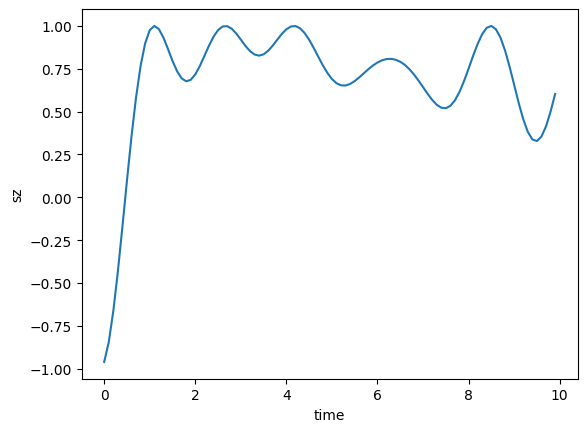

In [12]:
import matplotlib.pyplot as plt
plt.xlabel("time")
plt.ylabel("sz")
plt.plot([i*delta_t for i in range(num_steps)], exp_sz)

In [13]:
# Check the bond dimensions of the final mps:
# We can see that, despite setting the max_bond_dimension=4, the bond dimension has maxed out at 2.
psi[0]

[array([1]),
 array([0.86688502, 0.49850814]),
 array([0.83432395, 0.55127448]),
 array([0.82973395, 0.5581591 ]),
 array([0.82075523, 0.57128001]),
 array([0.75852493, 0.65164403]),
 array([0.78948725, 0.61376696]),
 array([0.84229601, 0.53901525]),
 array([0.85360351, 0.52092327]),
 array([0.85696895, 0.51536804]),
 array([0.88185797, 0.47151513]),
 array([1])]